# Using Torchbearer with PyTorch DataParallel

PyTorch offers a very simple way to take advantage of multiple GPUs when training large models on lots of data through [DataParallel](https://pytorch.org/docs/stable/nn.html?highlight=data%20parallel#torch.nn.DataParallel). They have a very good tutorial on how to use this for base PyTorch models [here](https://pytorch.org/tutorials/beginner/blitz/data_parallel_tutorial.html) and we recommend you familiarise yourself with that before moving on with this tutorial. 

**Note**: If your model doesn't require state on forward then Torchbearer works immediately with DataParallel without needing any of the steps in this tutorial. 

Unfortunately, DataParallel cannot directly pass the main Torchbearer state dictionary to models running on multiple GPUs, which leads to problems when you have large Torchbearer models which need to access and manipulate state on the forward pass. In this tutorial we demonstrate a callback that allows us to use such models across multiple devices without loss of functionality. 


**Note**: The easiest way to use this tutorial is as a colab notebook, which allows you to dive in with no setup. We recommend you enable a free GPU with

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

## Install Torchbearer

First we install torchbearer if needed. 

In [7]:
#%%
try:
    !pip install -q /home/matt/PycharmProjects/PyTorch-bink
    import torchbearer
except:
    !pip install -q torchbearer
    import torchbearer
    
    # If problems arise, try
    # pip install git+https://github.com/pytorchbearer/torchbearer
    # import torchbearer
    
    
    
print(torchbearer.__version__)

# Create some state keys for this example
A_KEY = torchbearer.state_key('a_key')
NEW_KEY = torchbearer.state_key('new_key')


0.4.0.dev


## UnpackState Callback

The callback that we will be using throughout this example to interface with state in DataParallel is called the UnpackState callback. This callback takes a list of keys which are the items in state that you wish to access and packs them as a dictionary (under the same keys) which gets passed to the model forward. 

For a quick example, we build a very simple model that just prints the input. Then we create an unpacker callback that asks for the keys torchbearer.X and a newly defined key A_KEY, which we populate before the run. We then run a Trial with this callback and model and observe that the model gets passed a dictionary with these two keys and their values. 

In [8]:
import torch
import torch.nn as nn

from torchbearer.callbacks import UnpackState
from torchbearer import Trial

class TestModel(nn.Module):
    def forward(self, x):
        print(str(x).replace('\n', ''))
        return x
      
unpacker = UnpackState(keys=[torchbearer.X, A_KEY])

t = Trial(TestModel(), callbacks=[unpacker])
t.state[A_KEY] = 'test'
_ = t.with_train_data(torch.ones(10, 1), torch.ones(10, 1), batch_size=1, steps=1).run()

{x: tensor([[1.]]), a_key_1: 'test'}



Often when models interact with state they want to modify it in some way, by adding values or modifying existing ones. The UnpackState callback allows this by updating the main state based on the model output. When a model returns a dictionary which includes a torchbearer.Y_PRED key, the the state dictionary will be automatically updated based on this output. 

We demonstrate this below by printing a previously unpopulated value in state after a model forward pass. 

In [9]:
class TestModel2(nn.Module):
    def forward(self, x):
        return {torchbearer.Y_PRED: x, NEW_KEY: 'New Key is here'}
      
unpacker = UnpackState(output_to_state=True)

@torchbearer.callbacks.on_step_training
def print_state(state):
    print(state[NEW_KEY])

t = Trial(TestModel2(), callbacks=[unpacker, print_state])
_ = t.with_train_data(torch.ones(10, 1), torch.ones(10, 1), batch_size=1, steps=1).run()

New Key is here



## Building a more Advanced Model

One type of model that often needs to access state is a VAE. In this example we will take the same model from the VAE example notebook [here](https://torchbearer.readthedocs.io/en/latest/examples/notebooks.html#deep-learning) and run it with DataParallel across all available GPUs. 

We define a very similar model, but modified to utilise the UnpackState callback method rather than the full state dictionary. 

In [10]:
import torch.nn as nn
import torch.nn.functional as F

MU, LOGVAR = torchbearer.state_key('mu'), torchbearer.state_key('logvar')

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3)).view(-1, 1, 28, 28)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return {torchbearer.Y_PRED: self.decode(z), MU: mu, LOGVAR: logvar}

We now copy the loss functions and data related methods from the VAE example. 

In [11]:
# LOSSES 

def binary_cross_entropy(y_pred, y_true):
    BCE = F.binary_cross_entropy(y_pred.view(-1, 784), y_true.view(-1, 784), reduction='sum').view(1) # DataParallel doesnt like size([]) tensors
    return BCE
  
def kld(mu, logvar):
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return KLD

main_loss = binary_cross_entropy

@torchbearer.callbacks.add_to_loss
def add_kld_loss_callback(state):
    KLD = kld(state[MU], state[LOGVAR])
    return KLD
  
# DATA
from torch.utils.data.dataset import Dataset
import torchvision
from torchvision import transforms
from torchbearer.cv_utils import DatasetValidationSplitter

class AutoEncoderMNIST(Dataset):
    def __init__(self, mnist_dataset):
        super().__init__()
        self.mnist_dataset = mnist_dataset

    def __getitem__(self, index):
        character, label = self.mnist_dataset.__getitem__(index)
        return character, character

    def __len__(self):
        return len(self.mnist_dataset)


BATCH_SIZE = 128
transform = transforms.Compose([transforms.ToTensor()])

# Define standard classification mnist dataset with random validation set
dataset = torchvision.datasets.MNIST('./data/mnist', train=True, download=True, transform=transform)
splitter = DatasetValidationSplitter(len(dataset), 0.1)
basetrainset = splitter.get_train_dataset(dataset)
basevalset = splitter.get_val_dataset(dataset)
basetestset = torchvision.datasets.MNIST('./data/mnist', train=False, download=True, transform=transform)

# Wrap base classification mnist dataset to return the image as the target
trainset = AutoEncoderMNIST(basetrainset)
valset = AutoEncoderMNIST(basevalset)
testset = AutoEncoderMNIST(basetestset)

traingen = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
valgen = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
testgen = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

# IMAGING

from torchbearer.callbacks import imaging

targets = imaging.MakeGrid(torchbearer.TARGET, num_images=64, nrow=8)
targets = targets.on_test().to_pyplot().to_file('targets.png')

predictions = imaging.MakeGrid(torchbearer.PREDICTION, num_images=64, nrow=8)
predictions = predictions.on_test().to_pyplot().to_file('predictions.png')

Finally we can create the UnpackState callback and the Trial. 

We run with DataParallel across all the GPUs, which for this particular model is slower than just running on a single GPU, but for a very large model, this might be the only feasible way to run. 

Running on devices: [0, 1]


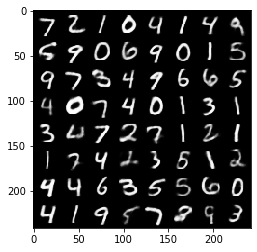

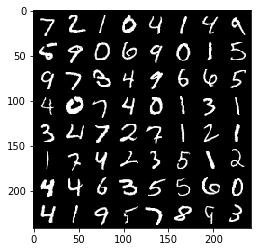

{'test_binary_acc': 0.9711006283760071, 'test_loss': 12256.4306640625}

In [12]:
import torch.optim as optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_devices = torch.cuda.device_count()

model = VAE()

try: 
    model = nn.DataParallel(model.to('cuda'), device_ids=list(range(num_devices)))
    print("Running on devices: {}".format(list(range(num_devices))))
except Exception as e:
    print("Cannot initialise DataParallel model.")
  
  
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss = binary_cross_entropy

trial = Trial(model, optimizer, main_loss, metrics=['acc', 'loss'],
                          callbacks=[UnpackState(output_to_state=True), add_kld_loss_callback, predictions, targets]).to(device)
trial.with_generators(train_generator=traingen, val_generator=valgen, test_generator=testgen)
_ = trial.run(epochs=10, verbose=1)
trial.evaluate(data_key=torchbearer.TEST_DATA)